In [1]:
PROJDIR=file.path('../../../data/raw_data/primate_peak_orthologs')

#######################################
### set up libraries and functions ####
ss <- function(x, pattern, slot = 1, ...) { 
  sapply(strsplit(x = x, split = pattern, ...), '[', slot) }
options(stringsAsFactors = F, repr.plot.width=14, repr.plot.height=6)
suppressMessages(library(Signac)); suppressMessages(library(Seurat))
suppressMessages(library(harmony))

source('../hal_scripts/narrowPeakFunctions.R')

In [2]:
# # set up future for parallelization
library(future)
library(future.apply)
plan("multiprocess", workers = parallel::detectCores()/2)
options(future.globals.maxSize = 35000 * 1024^2)

# 1) visualize unintegrated species clusters

In [3]:
## load the seurat object
saveRDS_fn = file.path(PROJDIR, 'rdas', 'linkOrthologMatrixSeurat.rds')
obj_seurat = readRDS(file = saveRDS_fn)

An object of class Seurat 
136780 features across 32107 samples within 1 assay 
Active assay: peaks (136780 features, 136780 variable features)
 2 dimensional reductions calculated: lsi, umap

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"


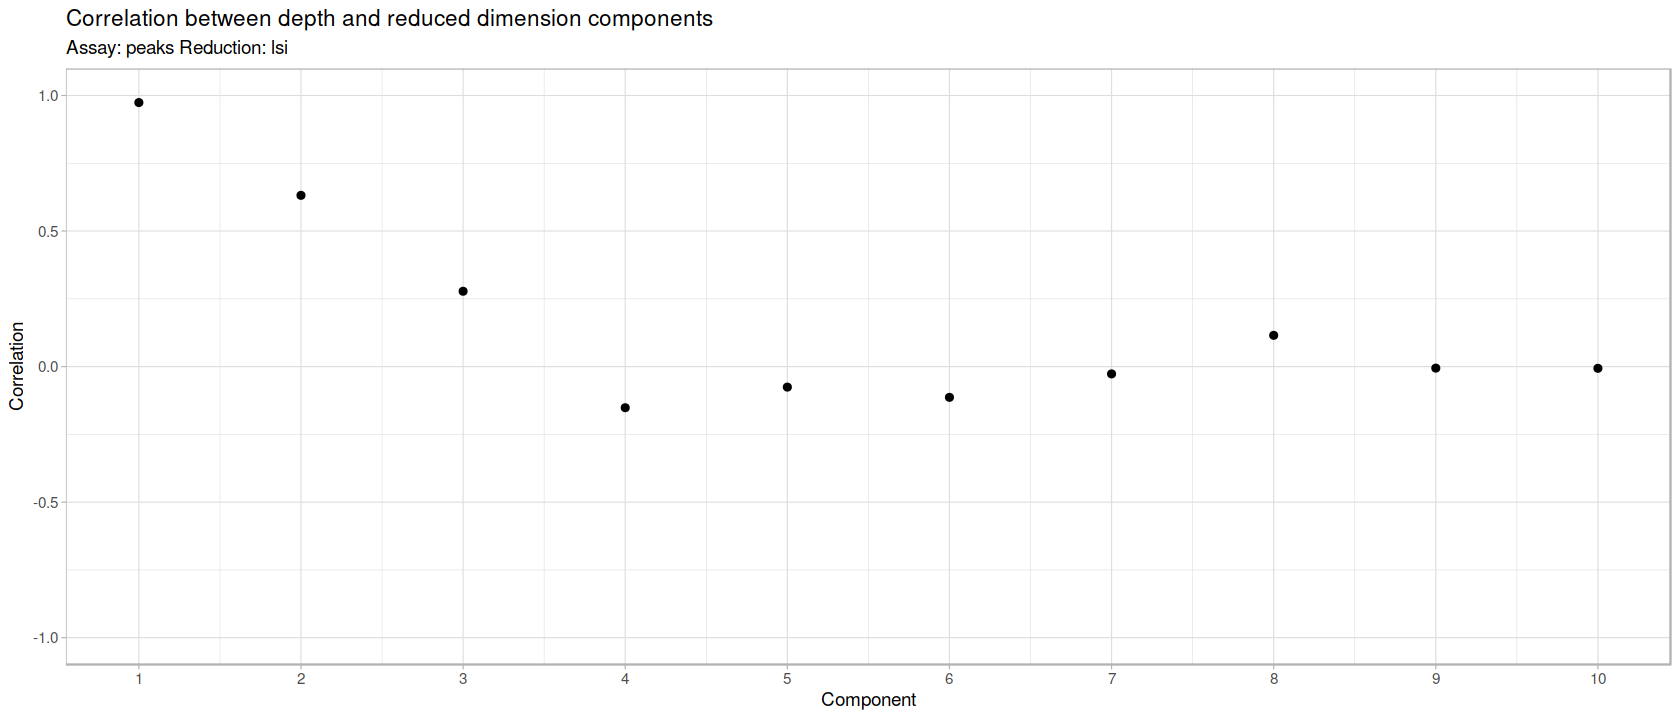

In [4]:
##  TF-IDF, SVD, and UMAP already performed on 'peaks' matrix
obj_seurat
obj_seurat@meta.data$log10nFrags = log10(obj_seurat@meta.data$nFrags)

# recompute UMAP b/c first and second PC correlate w/ depth
DepthCor(obj_seurat) # drop the first PC, correlated with number fragments
obj_seurat <- RunUMAP(object = obj_seurat, verbose = FALSE, reduction = 'lsi', dims = 3:30, umap.method = "uwot")

In [5]:
### subset to just 1 representative sample per species ###
cells = WhichCells(obj_seurat,expression = Sample %in% 
                     c('CAUD_WS1H_STA682A131', '14_1018.CAUD'))
obj_seurat = subset(obj_seurat, cells = cells)

## show cells per Species
table(obj_seurat@meta.data$Species)

## show cell clusters per sample
table(obj_seurat@meta.data$Clusters2, obj_seurat@meta.data$Species)


    hg38 rheMac10 
    7443     5793 

             
              hg38 rheMac10
  Astro        417     1035
  Interneuron  133      193
  Microglia    278      519
  MSN_D1       650      975
  MSN_D2       746      925
  MSN_UNK1      11      400
  MSN_UNK2      16        0
  Mural         68        0
  Oligo       4952     1442
  OPC          160      304
  VLMC          12        0

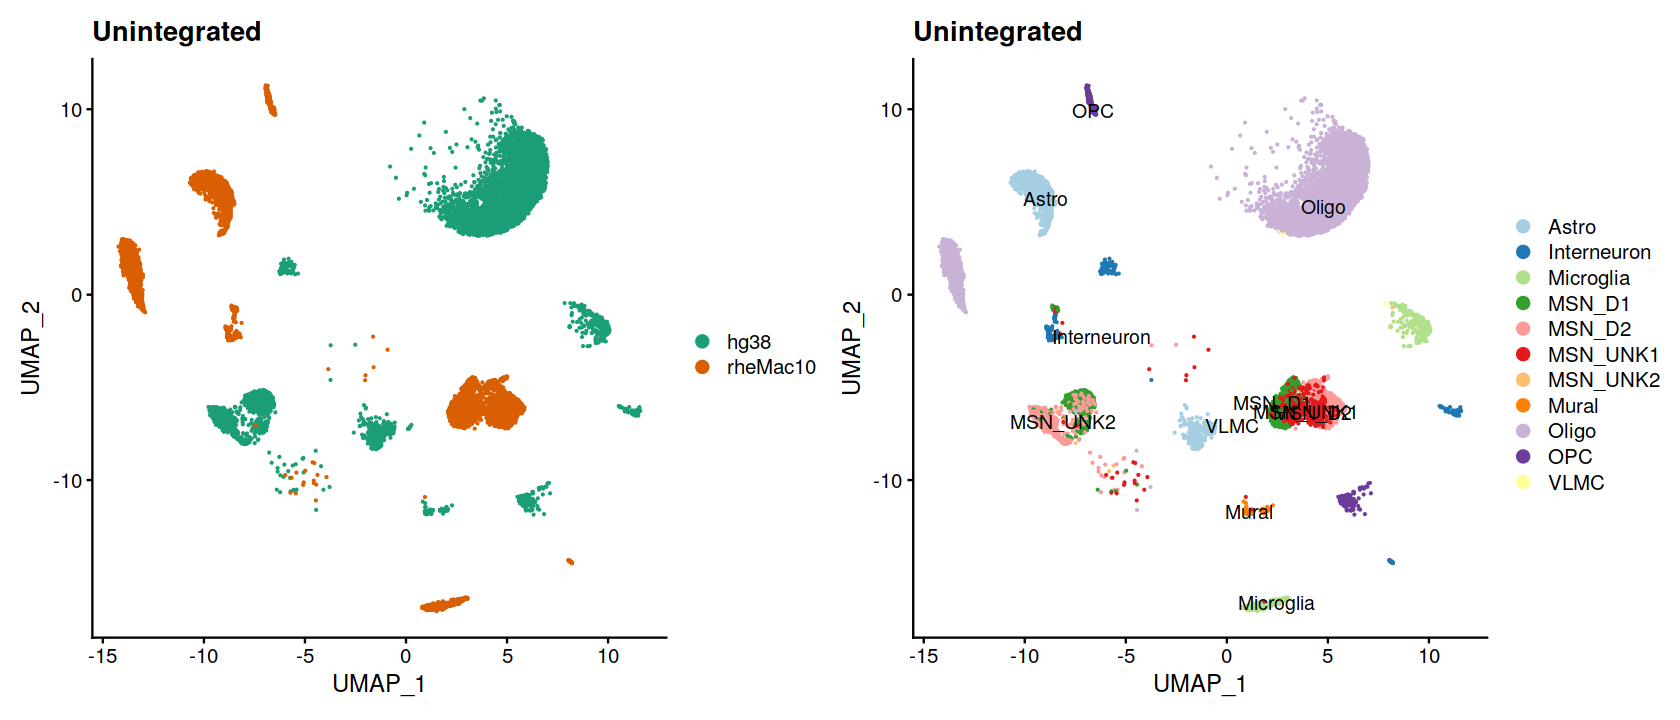

In [6]:
p_unintegrated_species = 
    DimPlot(object = obj_seurat, label = FALSE, group.by = 'Species', cols = 'Dark2') + 
    ggplot2::ggtitle("Unintegrated")

p_unintegrated_clusters2 = 
    DimPlot(object = obj_seurat, label = TRUE, group.by = 'Clusters2', cols = 'Paired') + 
    ggplot2::ggtitle("Unintegrated")

p_unintegrated_species + p_unintegrated_clusters2

# 2) integration with Harmony

Harmony 1/20

Harmony 2/20

Harmony converged after 2 iterations

Harmony 1/20

Harmony 2/20

Harmony converged after 2 iterations

Harmony 1/20

Harmony 2/20

Harmony converged after 2 iterations



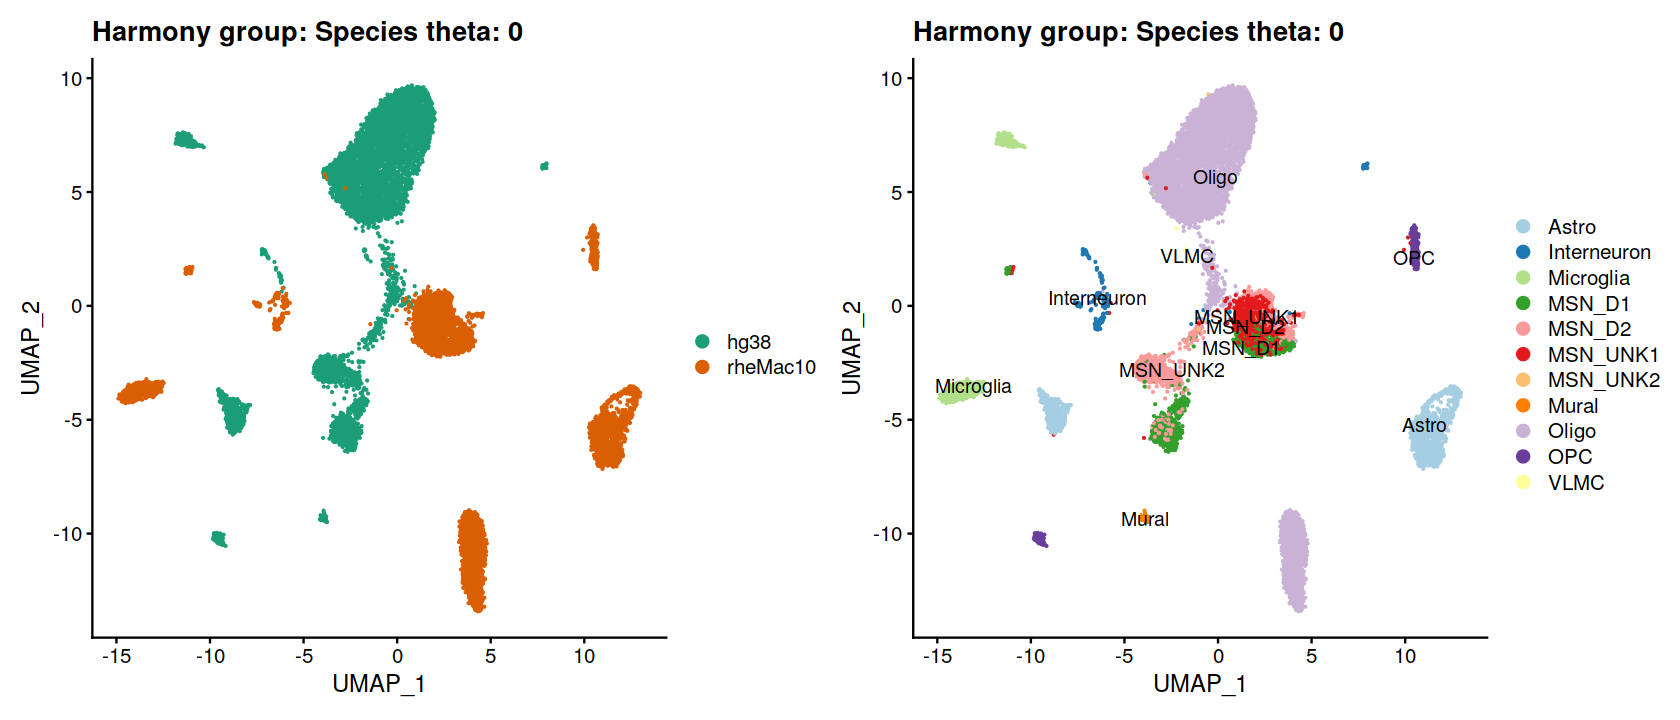

Harmony 1/20

Harmony 2/20

Harmony converged after 2 iterations



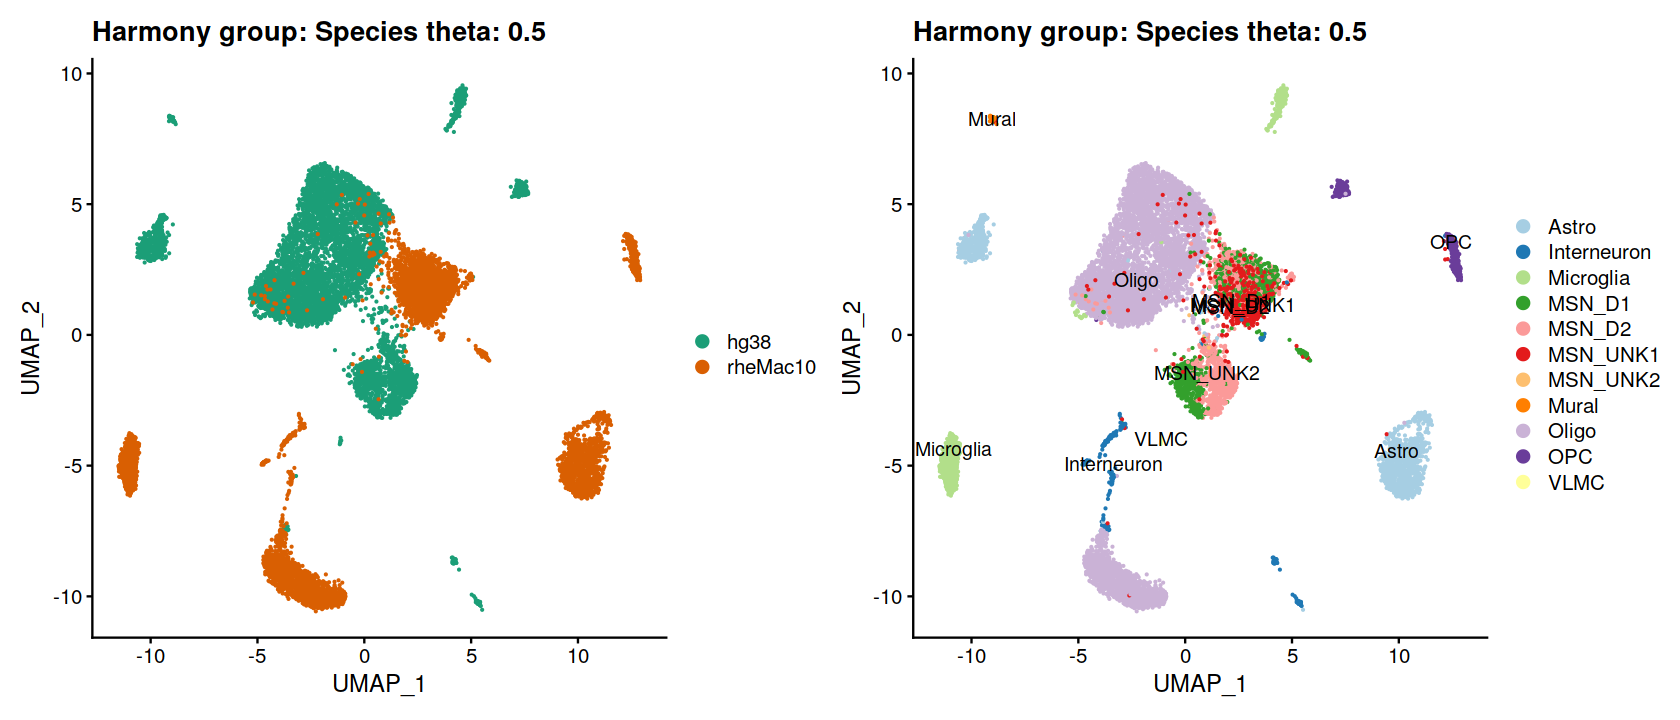

Harmony 1/20

Harmony 2/20

Harmony converged after 2 iterations



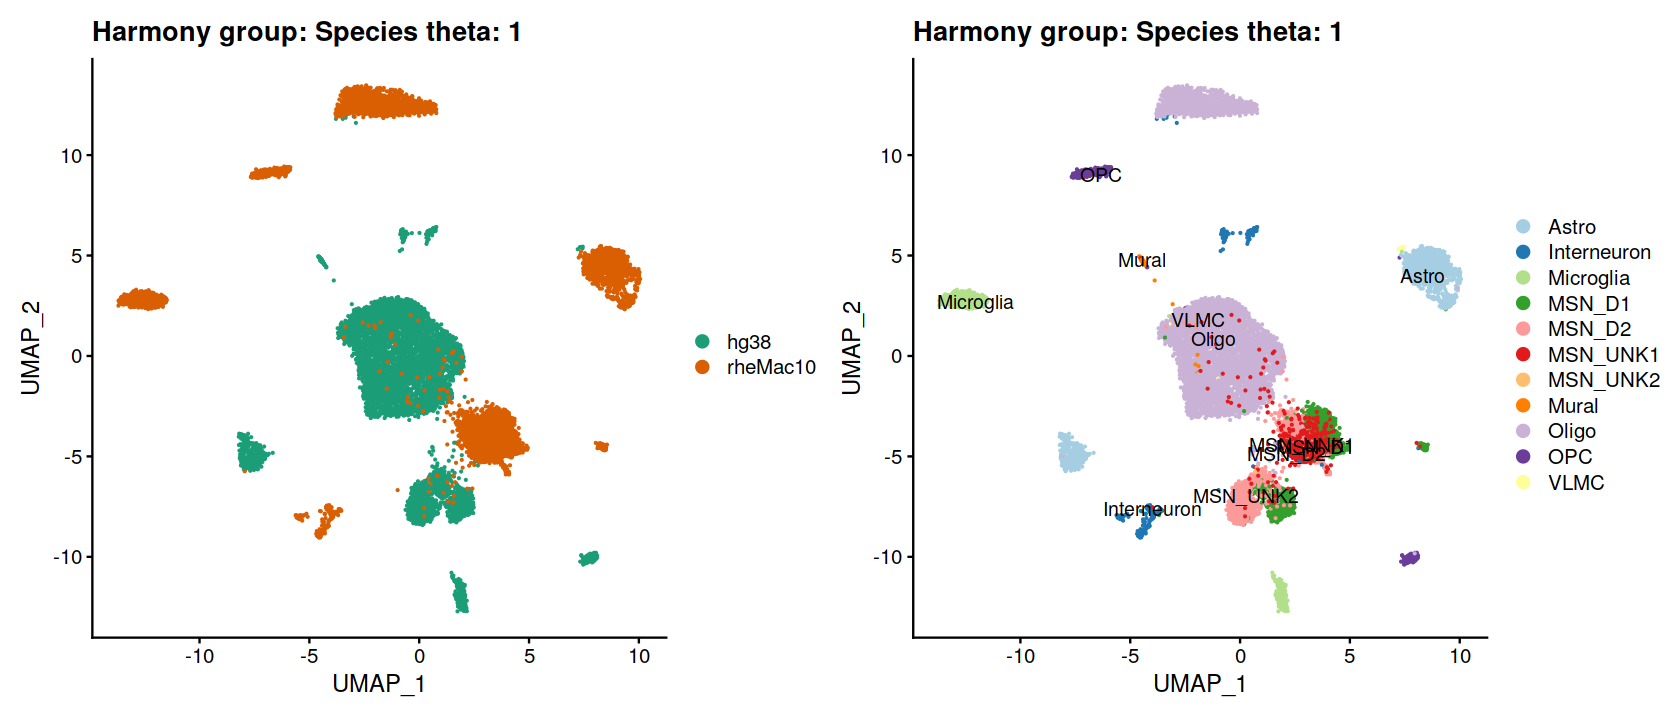

Harmony 1/20

Harmony 2/20

Harmony converged after 2 iterations



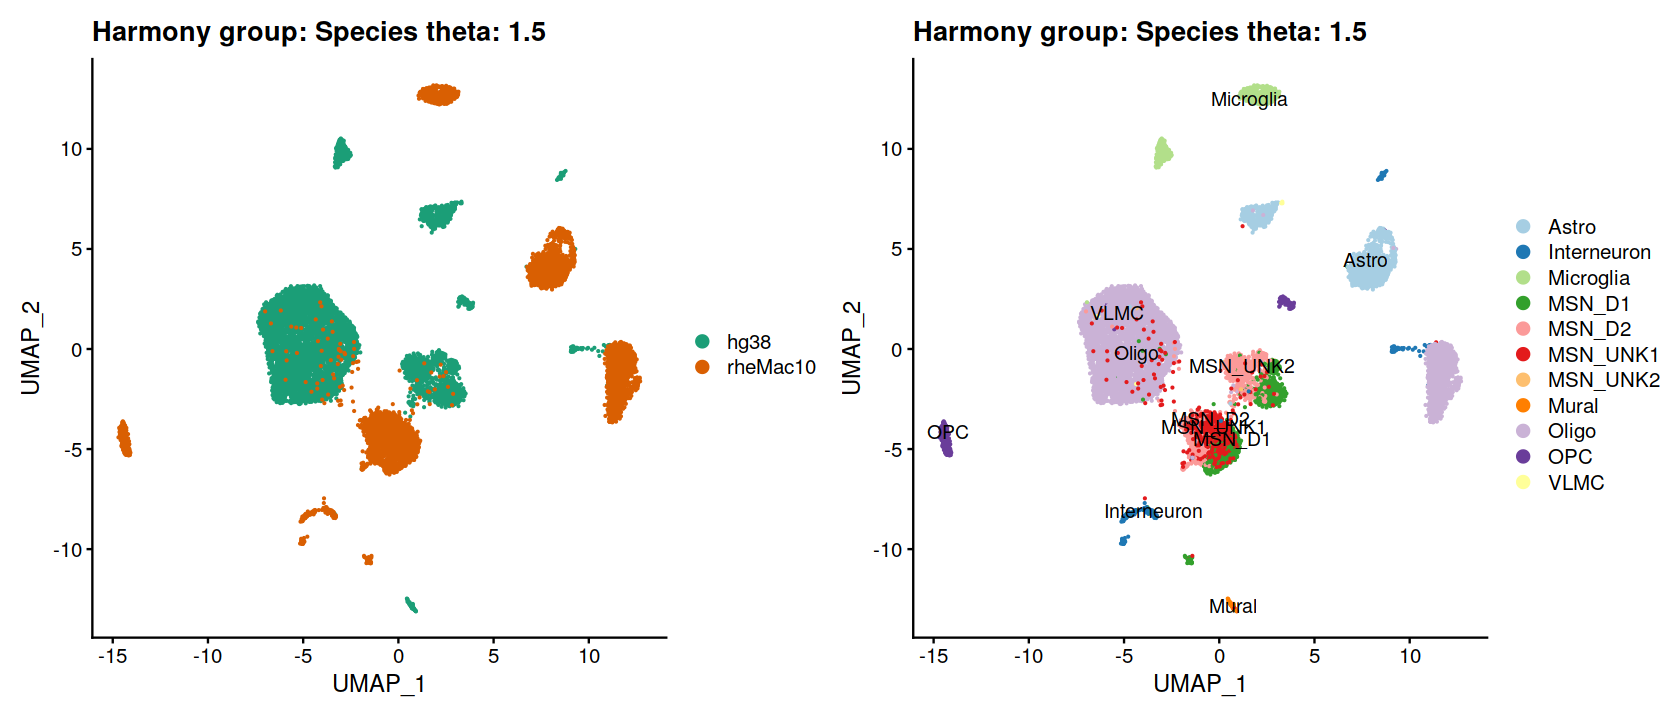

Harmony 1/20

Harmony 2/20

Harmony converged after 2 iterations



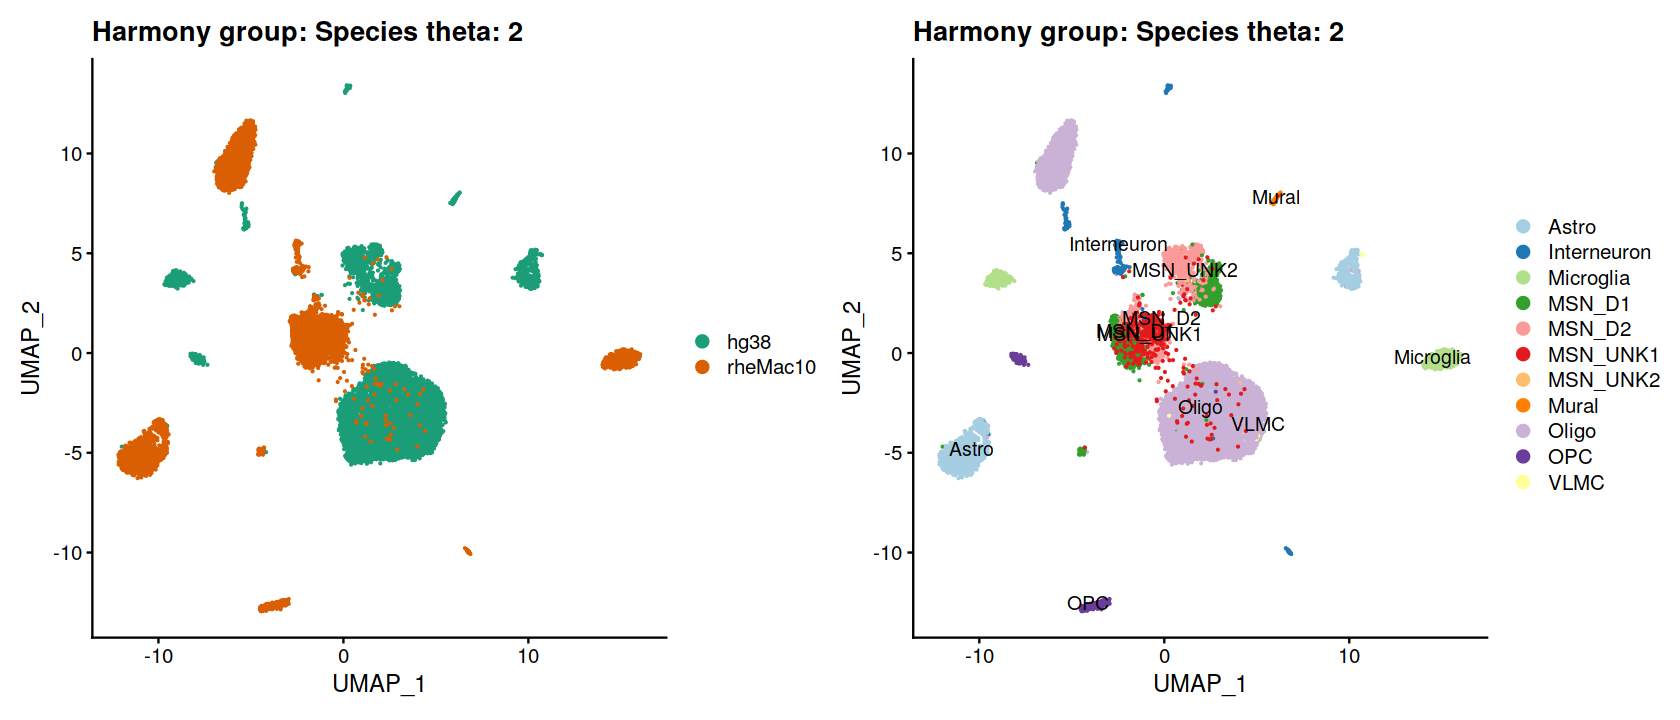

Harmony 1/20

Harmony 2/20

Harmony converged after 2 iterations



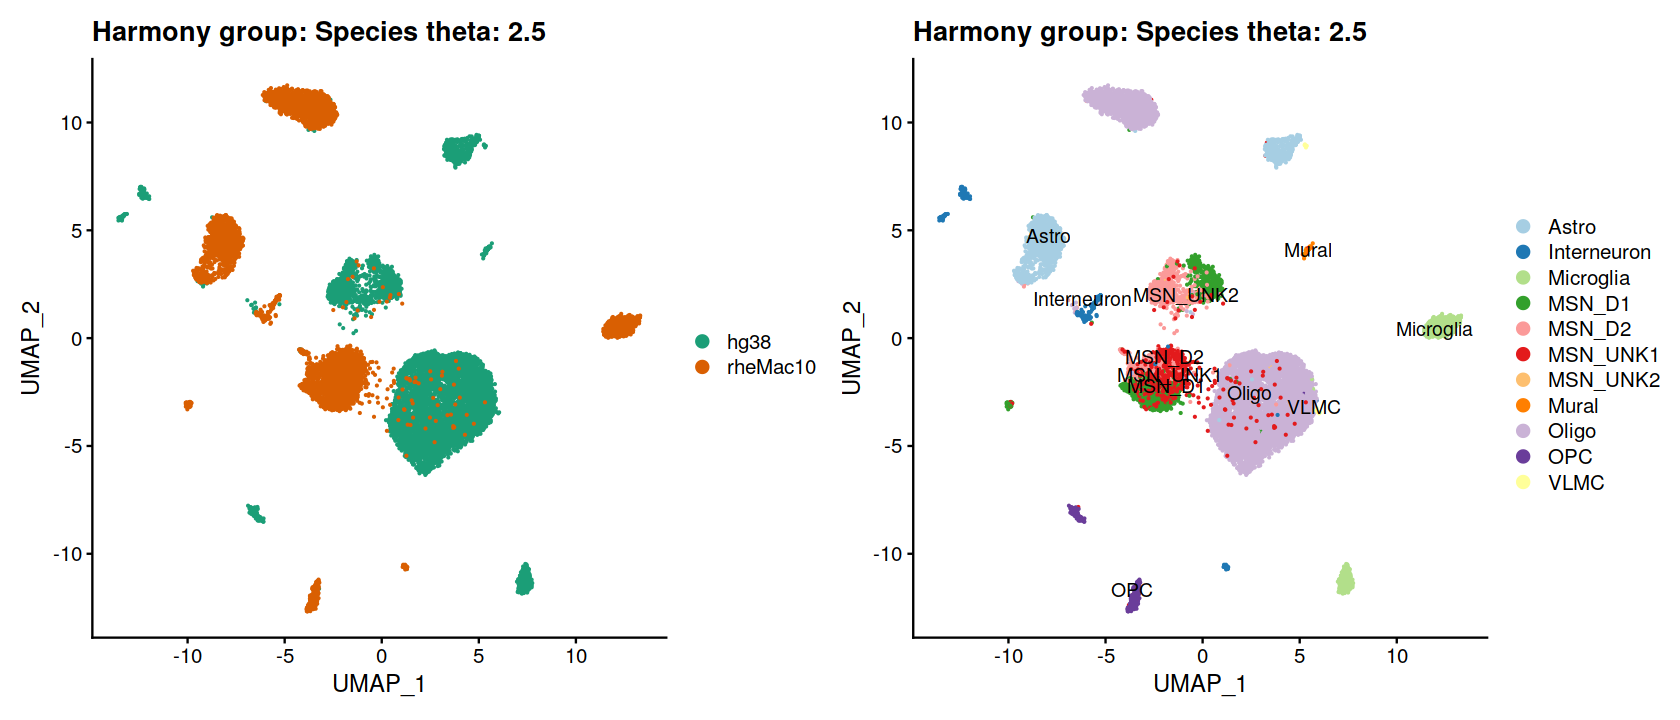

Harmony 1/20

Harmony 2/20

Harmony converged after 2 iterations



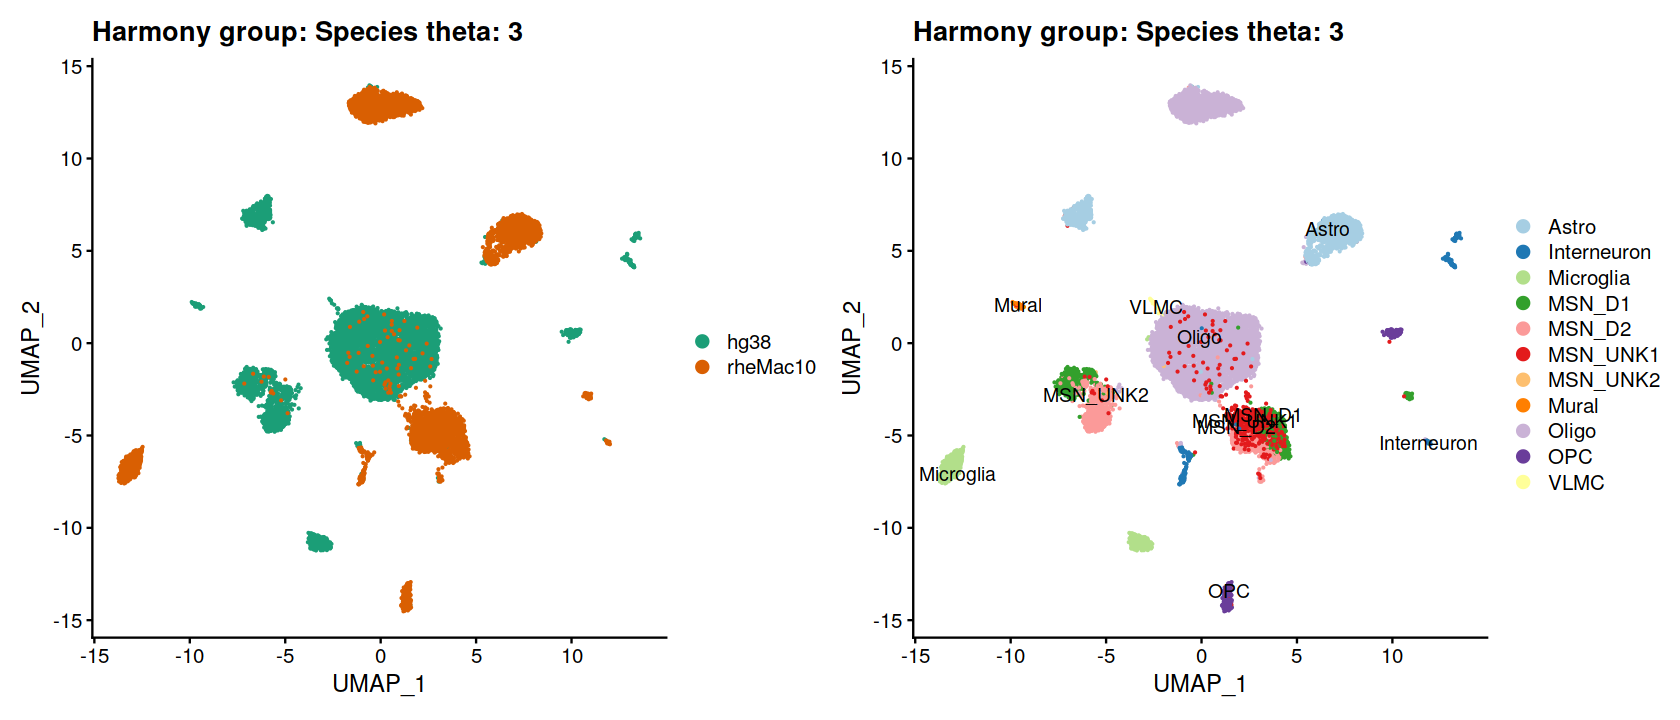

Harmony 1/20

Harmony 2/20

Harmony converged after 2 iterations



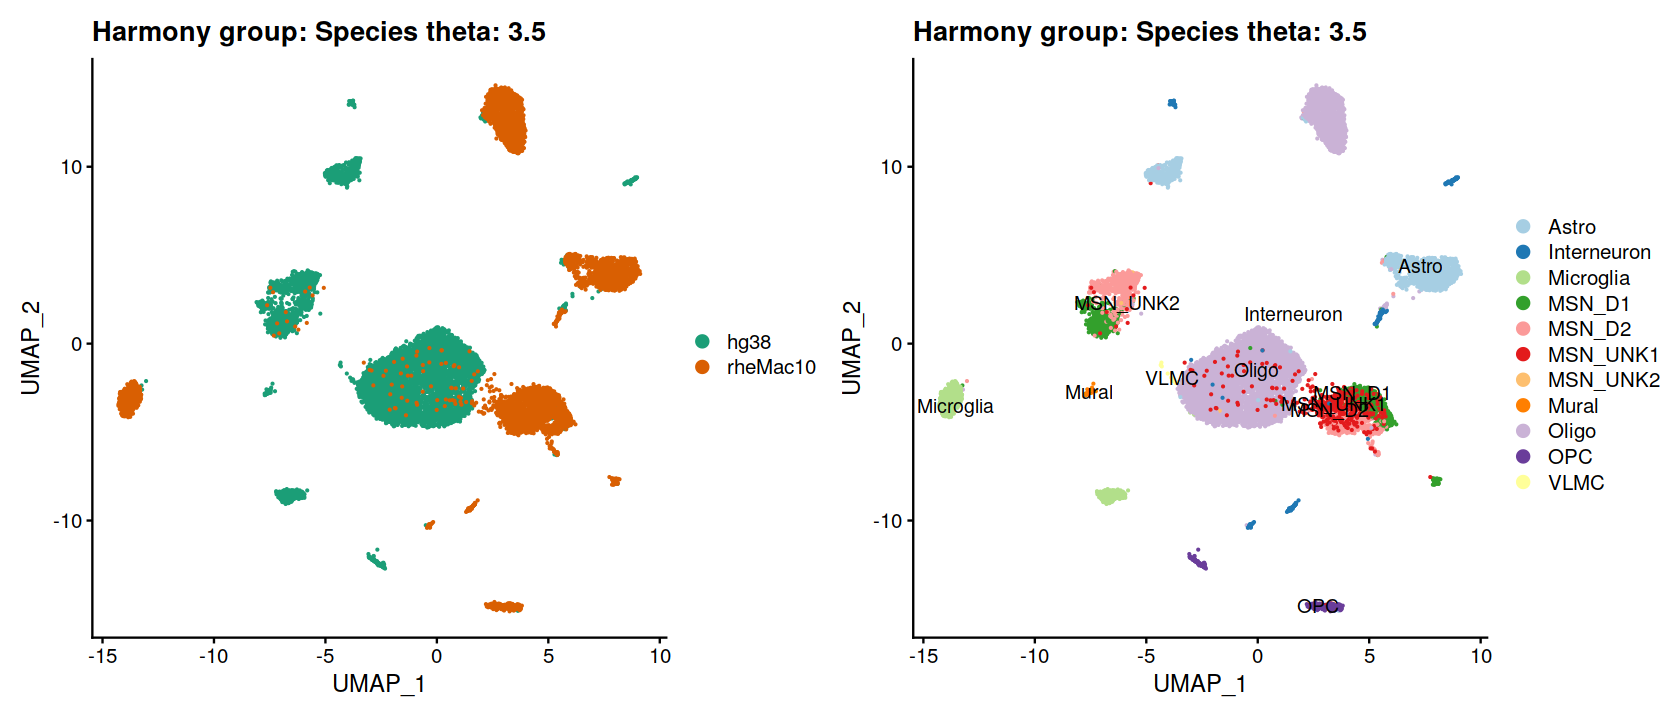

Harmony 1/20

Harmony 2/20

Harmony converged after 2 iterations



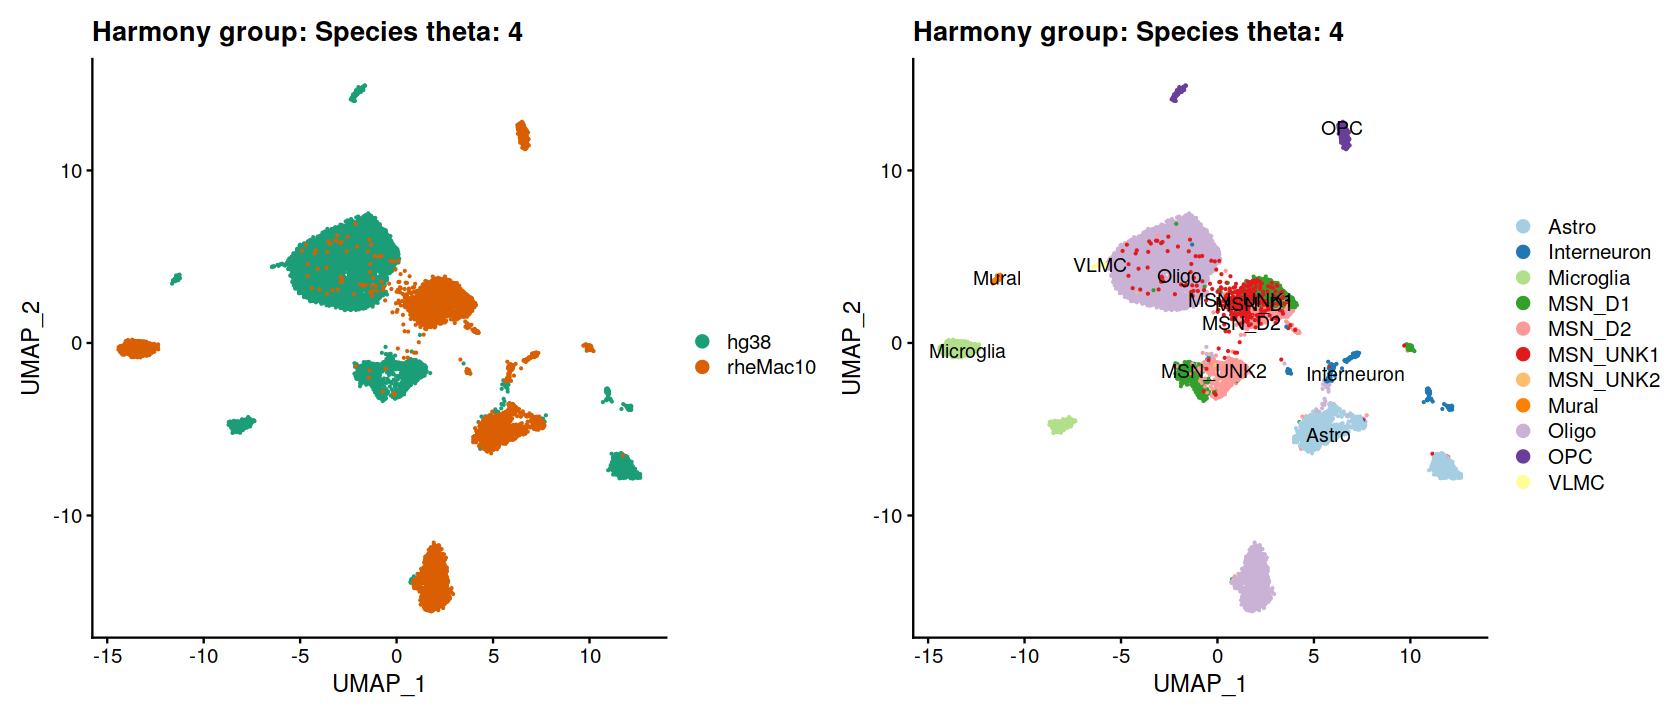

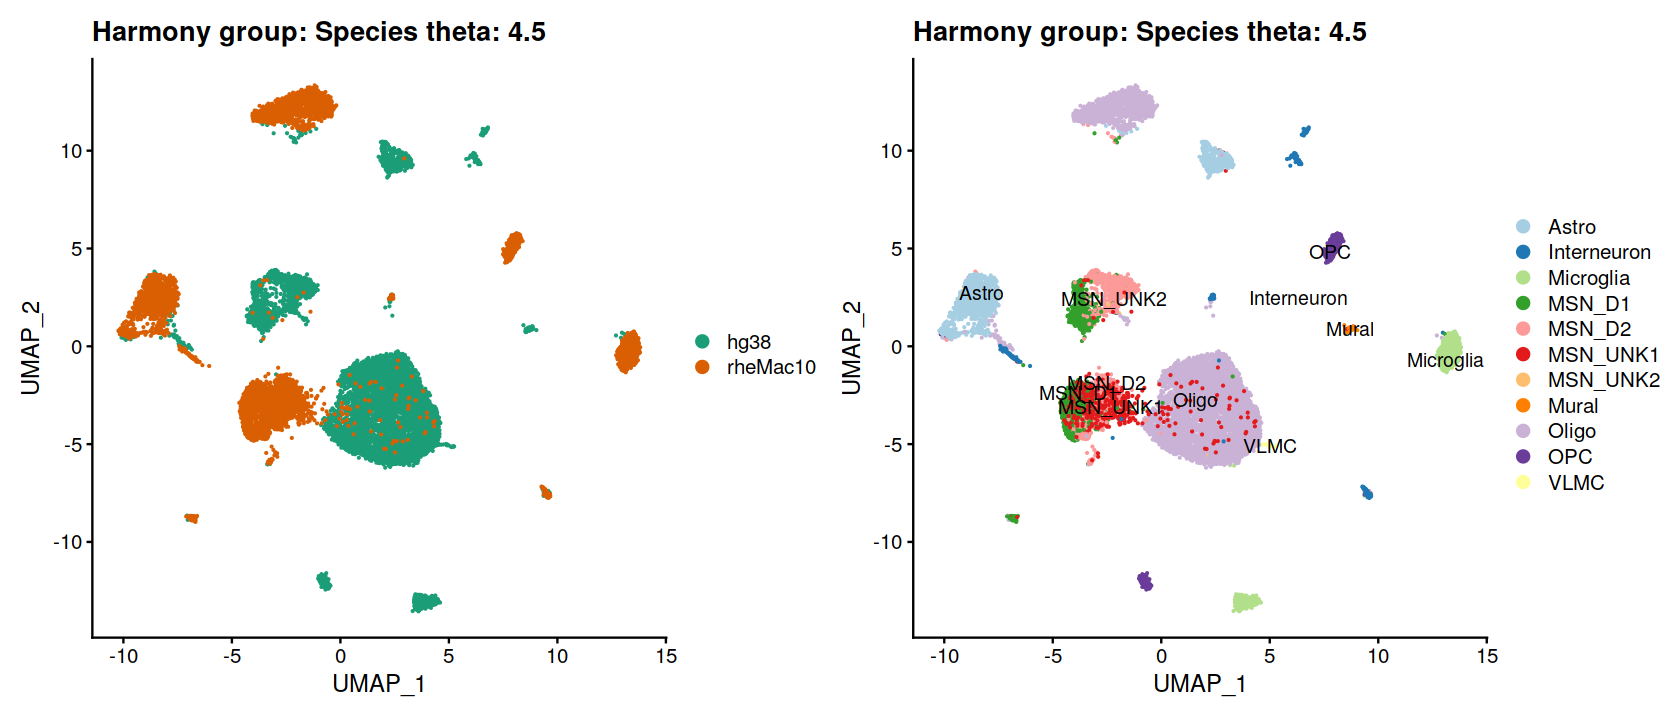

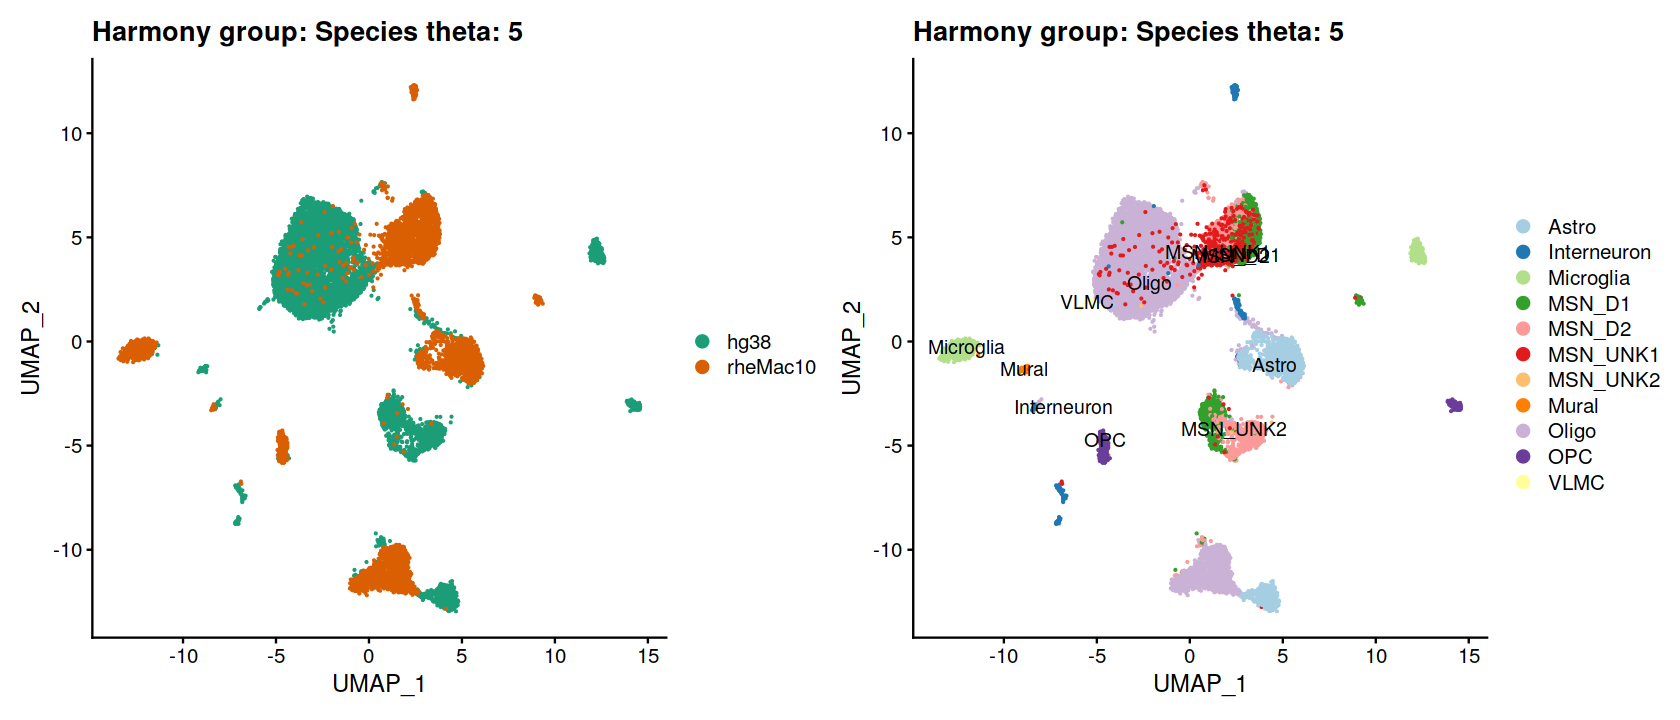

In [7]:
# group.by.vars = c('Species','TSSEnrichment'); theta = c(1, 2)
# group.by.vars = c('Species','TSSEnrichment','log10(nFrag)'); theta = c(1, 2, 2)
group.by.vars = c('Species'); theta = c(20)

for (theta in seq(0,5,.5)){
    set.seed(42)
    objHarmony <- RunHarmony(
        obj_seurat, group.by.vars = group.by.vars, theta = c(theta), 
        reduction.save = "harmony", reduction = "lsi", dims.use = 2:50, assay.use = "peaks",
        project.dim = FALSE, max.iter.harmony = 20, max.iter.cluster = 30)

    # re-compute the UMAP using corrected LSI embeddings
    objHarmony <- RunUMAP(object = objHarmony, umap.method = "uwot", 
                          verbose = FALSE, reduction = 'harmony', dims = 2:50)

    title = paste("Harmony",
                  "group:", paste(group.by.vars, collapse = ', '),
                  'theta:',paste(theta, collapse = ', '))

    # plot embeddings
    p_integrated_species = 
        DimPlot(object = objHarmony, label = FALSE, group.by = 'Species', cols = 'Dark2') +
        ggplot2::ggtitle(title)

    p_integrated_clusters2 = 
        DimPlot(object = objHarmony, label = TRUE, group.by = 'Clusters2', cols = 'Paired') +
        ggplot2::ggtitle(title)

    print(p_integrated_species + p_integrated_clusters2)
}